In [2]:
import pickle, gzip, urllib.request, json
import numpy as np
from tensorflow.keras.datasets import mnist

train_set, valid_set = mnist.load_data()
print(train_set[0].shape)

(60000, 28, 28)


This is a 5


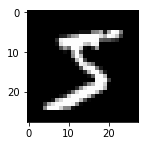

This is a 0


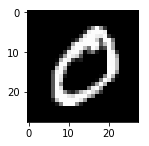

This is a 4


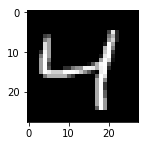

This is a 1


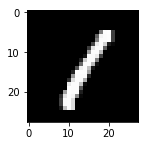

This is a 9


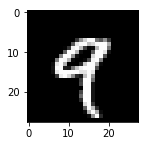

This is a 2


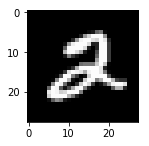

This is a 1


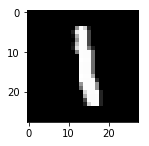

This is a 3


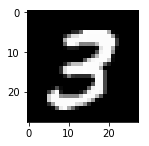

This is a 1


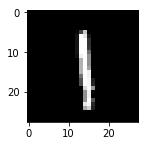

This is a 4


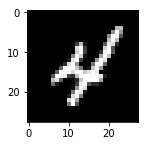

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()


In [6]:
for t in train_set[0]:
    t = t.reshape(784)
    print(t.shape)
    break

(784,)


In [7]:
import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

# role = "copy from AWS IAM assign sagemaker permission"
region = boto3.Session().region_name

bucket='agentz-ml-local' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', valid_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.reshape(784).tolist() for t in data_partition[0]]
        print(np.array(features).shape ,np.array(labels).shape)
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        
        np.savetxt('data.csv', examples, delimiter=',')
               
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
# convert_data()

In [8]:
import sagemaker

container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [9]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)

s3://agentz-ml-local/sagemaker/xgboost-mnist/train


In [10]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.xlarge',
                                         volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [11]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In [13]:
train_channel = sagemaker.inputs.TrainingInput(train_data, content_type='text/csv')
valid_channel = sagemaker.inputs.TrainingInput(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [14]:
xgb_model.fit(inputs=data_channels,  logs=True)

2021-05-30 06:36:26 Starting - Starting the training job...
2021-05-30 06:36:59 Starting - Launching requested ML instancesProfilerReport-1622356584: InProgress
......
2021-05-30 06:38:01 Starting - Preparing the instances for training......
2021-05-30 06:39:02 Downloading - Downloading input data...
2021-05-30 06:39:42 Training - Downloading the training image..Arguments: train
[2021-05-30:06:39:59:INFO] Running standalone xgboost training.
[2021-05-30:06:39:59:INFO] File size need to be processed in the node: 1310.11mb. Available memory size in the node: 8387.69mb
[2021-05-30:06:39:59:INFO] Determined delimiter of CSV input is ','
[06:39:59] S3DistributionType set as FullyReplicated
[06:40:07] 60000x784 matrix with 47040000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-30:06:40:07:INFO] Determined delimiter of CSV input is ','
[06:40:07] S3DistributionType set as FullyReplicated
[06:40:09] 10000x784 matrix with 7840000 entries loaded from

[06:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=5
[06:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=5
[06:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=5
[06:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=5
[06:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=5
[06:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=5
[06:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=5
[06:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max

In [15]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

----------------!

In [16]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [17]:
runtime_client = boto3.client('runtime.sagemaker')

In [20]:
with open('test_data', 'r') as f:
    for j in range(650,660):
        single_test = f.readline()
        response = runtime_client.invoke_endpoint(EndpointName = 'xgboost-2021-05-30-06-43-31-252',
                                         ContentType = 'text/csv',
                                         Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))

Predicted label is 7.0.
Predicted label is 2.0.
Predicted label is 1.0.
Predicted label is 0.0.
Predicted label is 4.0.
Predicted label is 1.0.
Predicted label is 4.0.
Predicted label is 9.0.
Predicted label is 5.0.
Predicted label is 9.0.


In [ ]:
import boto3
import json
 
endpoint = '<insert your endpoint here>'
 
runtime = boto3.Session().client('sagemaker-runtime')
 
csv_text = '1,-1.0,1.0,1.5,2.6'
# Send CSV text via InvokeEndpoint API
response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='text/csv', Body=csv_text)
# Unpack response
result = json.loads(response['Body'].read().decode())